# Documentation

How to use the mlp-framework and ddqn-framework. This notebook give a short overview of the basic usage.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gym
import time 

## Introduction  
What are the frameworks doing and what kind of abstraction to deal with.

### mlp-framework

To use the framework the hightest abstraction level to think of is the layer-object. Each layer-object is defined by it's number of inputs and neurons. Activation, regularization and momentum-learning paramesters are idependant of other layers and can be set idividually. So you could have a tanh activation in the first layer and then a ReLu in the second before i.e. calssifying with a logistic function.

In [ ]:
import mlp_framework as nn

### there are default settings, so this is the minimal code
### required to build a 5 layer neural network classifier

# initializing each layer with input and output size
A1 = nn.layer(INPUT_SIZE,512)
A2 = nn.layer(512,256)
A3 = nn.layer(256,128)
A4 = nn.layer(128,64)
AOUT = nn.layer(64,OUTPUT_SIZE)
# set the output layer activation to 'logistic transfer function' [0,1] 
AOUT.f = nn.f_lgtr
# pass list of layer in mlp model class 
model = nn.mlp([A1,A2,A3,A4,AOUT])


##################  TRAINING and PREICTION  ##################
# train th model with data and targets
for i in range(iterations):
    model.train(Data,targets) # rows are samples and columns are features
    
# for prediction call the model inference method with data
predictions = model.infer(Data)




### ddqn-framework  
This framework is for training Double Q network models build with mlp_framework.  
Pass the targetDQN and onlineDQN together with a configuration to create a learning environment.  
  
There are some useful tools in there if you want to tinker around yourself. i.e. a numpy replaybuffer



In [15]:
import ddqn_framework as DDQN

# STEP 1: create configuration
configuration = DDQN.trainer_config( game_name='Acrobot-v1',
                                BUFFER_SIZE = 50e3,
                                STEPS_PER_EPISODE = 500,
                                MAX_STEPS = 100000,   
                                UPDATE_TARGET_STEPS = 1000,
                                BATCH_SIZE = 32,
                                GAMMA = 0.99,
                                EXPLORATION = 100
                                )#game_name='CartPole-v0', game_name='LunarLander-v2'

# STEP 2: build models (online & target)
A1 = nn.layer(configuration.INPUT_SIZE,64)
AOUT = nn.layer(64,configuration.OUTPUT_SIZE)
AOUT.f = nn.f_iden

L1 = nn.layer(configuration.INPUT_SIZE,64)
LOUT = nn.layer(64,configuration.OUTPUT_SIZE)
LOUT.f = nn.f_iden
onlineNet = nn.mlp([A1,AOUT])
targetNet = nn.mlp([L1,LOUT])

# STEP 3: create trainer
ddqn = DDQN.trainer(onlineNet,targetNet,configuration)

# STEP 5: train the trainer (ddqn) for configuration.MAX_STEPS:
ddqn.train()
# OR: train the trainer (ddqn) for one episode(!) by setting 'flag' = True :
ddqn.train(True)

#  STEP 6: 
# get your models, config and logs from the trainer (see 'some useful stuff')

#################### some usefull stuff:
### save config
#first_config = ddqn.save_config()
### use new config ('new_config')
#ddqn.load_config(new_config)
### apply/get  model
#ddqn.onlineNet = new_onlineNet
#trained_targetNet  = ddqn.targetNet
### clear REPLAY BUFFER
#ddqn.REPLAY_BUFFER = ringbuffer(ddqn.BUFFER_SIZE)
### get reward / loss logs
#loss_list = ddqn.loss_plot
#reward_list = ddqn.reward_plot

[2018-01-10 17:40:56,050] Making new env: Acrobot-v1
[2018-01-10 17:40:56,050] Making new env: Acrobot-v1


update ----  1  episodes played |||| 10 eps average reward:  -501.0
step  2000 exploration: 0.049164 sec/step: 0.001050779498334066
update ----  3  episodes played |||| 10 eps average reward:  -501.0
update ----  5  episodes played |||| 10 eps average reward:  -501.0
step  4000 exploration: 0.024789 sec/step: 0.0010714877561652258
update ----  7  episodes played |||| 10 eps average reward:  -501.0
update ----  9  episodes played |||| 10 eps average reward:  -501.0
step  6000 exploration: 0.016573 sec/step: 0.0011391035139824907
update ----  11  episodes played |||| 10 eps average reward:  -501.0
update ----  13  episodes played |||| 10 eps average reward:  -501.0
step  8000 exploration: 0.012447 sec/step: 0.0011964410361851492
update ----  15  episodes played |||| 10 eps average reward:  -501.0
update ----  17  episodes played |||| 10 eps average reward:  -501.0
step  10000 exploration: 0.01 sec/step: 0.0012583528711027725
update ----  19  episodes played |||| 10 eps average reward:  -

#### Plotting loss and reward

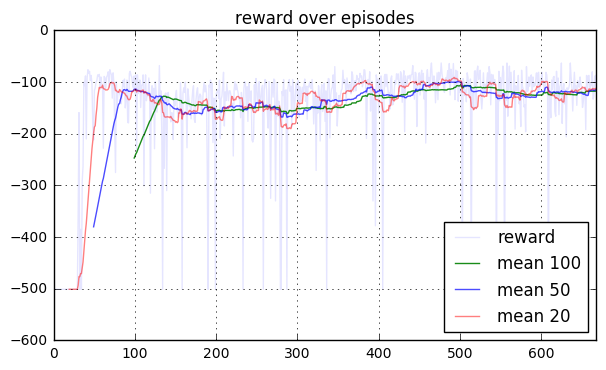

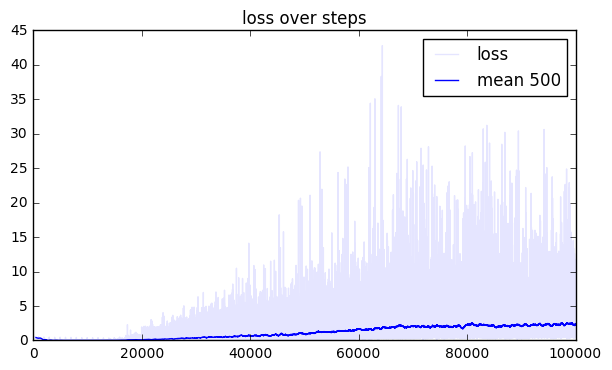

In [20]:
reward_plot = np.array(ddqn.reward_plot)
loss_plot = np.array(ddqn.loss_plot)

rewdata = pd.Series(reward_plot)
lossdata = pd.Series(loss_plot)

plt.figure(figsize=(7,4))
rewdata.plot(alpha=0.1,color='b',label='reward')
rewdata.rolling(window=100).mean().plot(style='g',alpha=.9,label='mean 100')
rewdata.rolling(window=50).mean().plot(style='b',alpha=.7,label='mean 50')
rewdata.rolling(window=20).mean().plot(style='r',alpha=.5,label='mean 20')
plt.legend(loc='lower right')
plt.grid()
plt.title('reward over episodes')
plt.figure(figsize=(7,4))
lossdata.plot(alpha=0.1,color='b',label='loss')
lossdata.rolling(window=500).mean().plot(style='b',label='mean 500')
plt.legend()
plt.title('loss over steps')
plt.show()

#### See the DDQN in action

In [21]:
envX = gym.make(configuration.game_name).env#('MountainCar-v0')#('Alien-v0')#('LunarLander-v2')
for i_episode in range(20):  ## number of games to be played
    observation = envX.reset()
    rew = 0.
    for t in range(configuration.STEPS_PER_EPISODE):
        envX.render()
        action = np.argmax(ddqn.targetNet.infer(observation[True,:]))
        observation, reward, done, info = envX.step(action)
        rew += reward
        if done or (t+1) >= configuration.STEPS_PER_EPISODE:
            print("Episode finished after {} timesteps with reward {}".format(t+1,rew))
            time.sleep(3)
            break

[2018-01-10 17:50:47,760] Making new env: Acrobot-v1


Episode finished after 113 timesteps with reward -112.0
Episode finished after 266 timesteps with reward -265.0
Episode finished after 72 timesteps with reward -71.0
Episode finished after 70 timesteps with reward -69.0
Episode finished after 113 timesteps with reward -112.0
Episode finished after 125 timesteps with reward -124.0
Episode finished after 103 timesteps with reward -102.0
Episode finished after 89 timesteps with reward -88.0
Episode finished after 500 timesteps with reward -500.0
Episode finished after 137 timesteps with reward -136.0
Episode finished after 107 timesteps with reward -106.0
Episode finished after 113 timesteps with reward -112.0
Episode finished after 102 timesteps with reward -101.0
Episode finished after 89 timesteps with reward -88.0
Episode finished after 71 timesteps with reward -70.0
Episode finished after 92 timesteps with reward -91.0
Episode finished after 122 timesteps with reward -121.0
Episode finished after 121 timesteps with reward -120.0
Epis